# San Francisco Crime Classification from a top ranker

본 notebook은 Yannis Pappas 커널을 참고하여 작성했습니다. (https://www.kaggle.com/yannisp/sf-crime-analysis-prediction)

## Data Science Life Cycle
Data Science Life Cycle은 아래의 단계로 구성되어 있으며, 본 경진 대회에서도 아래의 전체 Life Cycle대로 진행할 예정입니다.
1. 데이터 품질을 향상시키기 위한 Data Wrangling
2. 탐색적 데이터 분석 (EDA)
3. 현재 Feature들을 기반으로 추가적인 Feature들을 만드는 Feature Engineering
4. (필요 시) 데이터 정규화 및 변환
5. 모델 성능 측정을 위한 훈련 데이터, 테스트 데이터 생성 및 파라미터 조정
6. 모델 선택 및 평가, 결과 예측을 위한 모델 생성

In [1]:
import pandas as pd
from shapely.geometry import  Point
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import cm
import urllib.request
import shutil
import zipfile
import os
import re
import contextily as ctx
import geoplot as gplt
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import shap

In [2]:
train = pd.read_csv('data/train.csv', parse_dates=['Dates'])
test = pd.read_csv('data/test.csv', parse_dates=['Dates'], index_col='Id')

In [3]:
train.Dates.describe()

count                  878049
unique                 389257
top       2011-01-01 00:01:00
freq                      185
first     2003-01-06 00:01:00
last      2015-05-13 23:53:00
Name: Dates, dtype: object

In [4]:
train.shape

(878049, 9)

훈련 데이터는 2003.1.6.부터 2015.5.13.까지의 범죄를 담고 있으며, 총 9개의 features가 있습니다.

In [5]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


- Dates - 범죄가 일어난 일시
- Category - 범죄 유형 (이 값이 Target variable임)
- Descript - 범죄에 대한 자세한 설명
- DayOfWeek - 요일
- PdDistrict - 경찰 관할 지역 명칭
- Resolution - 범죄 해결 여부
- Address - 범죄 발생 주소
- X - 경도(Longitude)
- Y - 위도(Latitude)

In [6]:
train.dtypes

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
dtype: object

object type, 즉 string type은 카테고리형 데이터이기 때문에 추후 인코딩이 필요합니다.

In [7]:
train.duplicated().sum()

2323

2323개의 중복행이 존재해 제거해줘야 합니다.

In [8]:
def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
    gdf['Coordinates'] = gdf['Coordinates'].apply(Point)
    gdf = gpd.GeoDataFrame(gdf, geometry='Coordinates',
                          crs={'init': 'epsg:4326'})
    return gdf

train_gdf = create_gdf(train)

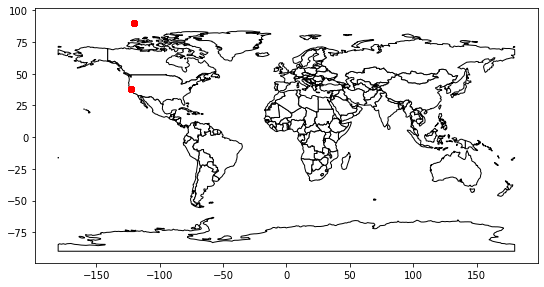

In [9]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

f, ax = plt.subplots(1, figsize=(9,9))
ax = world.plot(color='white', edgecolor='black', axes=ax)
train_gdf.plot(ax=ax, color='red');

캘리포니아 지역의 범죄에 대한 데이터인데 엉뚱한 곳에 찍혀 있는 데이터가 있습니다. 어떤 데이터인지 확인해보겠습니다.

In [10]:
train_gdf[train_gdf.Y > 70]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Coordinates
660485,2005-12-30 17:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,TENDERLOIN,NONE,5THSTNORTH ST / OFARRELL ST,-120.5,90.0,POINT (-120.50000 90.00000)
660711,2005-12-30 00:34:00,ASSAULT,INFLICT INJURY ON COHABITEE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0,POINT (-120.50000 90.00000)
660712,2005-12-30 00:34:00,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0,POINT (-120.50000 90.00000)
661106,2005-12-29 00:07:00,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Thursday,TENDERLOIN,PSYCHOPATHIC CASE,5THSTNORTH ST / EDDY ST,-120.5,90.0,POINT (-120.50000 90.00000)
666430,2005-11-30 11:25:00,OTHER OFFENSES,TRAFFIC VIOLATION,Wednesday,TENDERLOIN,"ARREST, CITED",5THSTNORTH ST / ELLIS ST,-120.5,90.0,POINT (-120.50000 90.00000)
...,...,...,...,...,...,...,...,...,...,...
844995,2003-06-11 08:49:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Wednesday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0,POINT (-120.50000 90.00000)
845842,2003-06-09 09:25:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Monday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0,POINT (-120.50000 90.00000)
852880,2003-05-02 01:00:00,SEX OFFENSES FORCIBLE,"FORCIBLE RAPE, BODILY FORCE",Friday,SOUTHERN,COMPLAINANT REFUSES TO PROSECUTE,3RD ST / JAMES LICK FREEWAY HY,-120.5,90.0,POINT (-120.50000 90.00000)
857248,2003-04-14 16:30:00,ROBBERY,"ROBBERY ON THE STREET, STRONGARM",Monday,BAYVIEW,COMPLAINANT REFUSES TO PROSECUTE,GILMAN AV / FITCH ST,-120.5,90.0,POINT (-120.50000 90.00000)


In [11]:
train_gdf[train_gdf.Y > 70].count()[0]

67

총 67개의 데이터의 좌표가 잘못되어 있습니다.
우선, 중복행은 제거를 시켜줍니다. 그리고 67개의 outlier는 평균값으로 대체합니다.

In [12]:
train.drop_duplicates(inplace=True)

In [13]:
train.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

In [14]:
imputer = SimpleImputer(strategy='mean')

In [15]:
for district in train['PdDistrict'].unique():
    train.loc[train['PdDistrict']==district, ['X', 'Y']] = imputer.fit_transform(
        train.loc[train['PdDistrict']==district, ['X', 'Y']])
    # fit은 train 데이터로 해주었기때문에 transform만 적용
    test.loc[test['PdDistrict']==district, ['X', 'Y']] = imputer.transform(
        test.loc[test['PdDistrict']==district, ['X', 'Y']])    
    
train_gdf = create_gdf(train)

### 날짜와 요일

In [16]:
train['Date'] = train['Dates'].dt.date
train['Year'] = train['Dates'].dt.year
train['Month'] = train['Dates'].dt.month
train['Day'] = train['Dates'].dt.day
train['Hour'] = train['Dates'].dt.hour

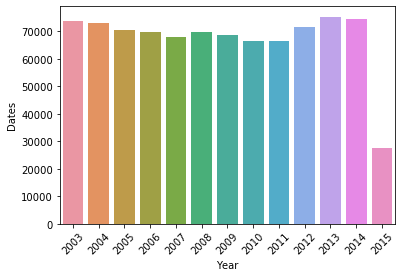

In [17]:
year_series = train.groupby('Year').count().iloc[:, 0]
g = sns.barplot(x=year_series.index, y=year_series)
g.set_xticklabels(g.get_xticklabels(), rotation=45);

연도에 따른 범죄수입니다. 2003년부터 2014년까지는 범죄수가 거의 유사했지만, 2015년에 급감한 수치를 보입니다.

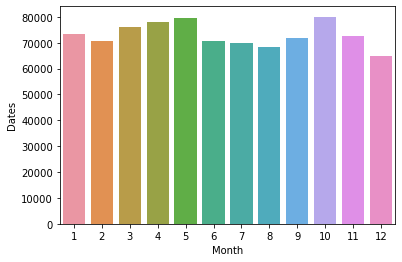

In [18]:
month_series = train.groupby('Month').count().iloc[:, 0]
sns.barplot(x=month_series.index, y=month_series);

월에 따른 범죄수입니다. 8월, 12월에 범죄수가 가장 적었고, 5월, 10월에 가장 많았습니다. 날씨가 안 좋을 때 (더울 때 혹은 추울 때)는 범죄도 적고, 날씨가 좋을 때는 범죄도 많다는 것을 알 수 있습니다.

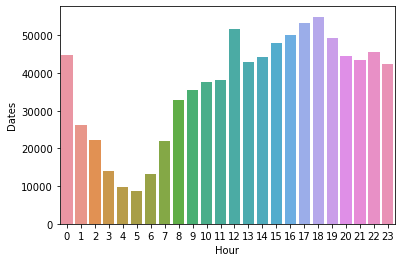

In [19]:
hour_series = train.groupby('Hour').count().iloc[:, 0]
sns.barplot(x=hour_series.index, y=hour_series);

시간에 따른 범죄수입니다. 예상대로 모두가 잠든 새벽 시간에 범죄가 가장 적고, 18시가 가장 많습니다. 아침부터 18시까지 점차 증가하는 추세를 보이는데 12시에 유독 많은 것을 볼 수 있습니다. 점심 시간, 저녁 시간 등과 관련이 있지 않나 추측해봅니다.

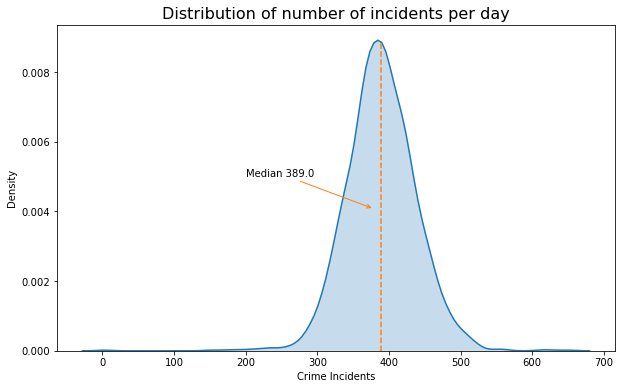

In [20]:
palette = sns.color_palette()

plt.figure(figsize=(10, 6))
date_count = train.groupby('Date').count().iloc[:, 0]
sns.kdeplot(data=date_count, shade=True)
plt.axvline(x=date_count.median(), ymax=0.95, linestyle='--', color=palette[1])
plt.annotate('Median ' + str(date_count.median()),
             xy=(date_count.median(), 0.004),
             xytext=(200, 0.005),
             arrowprops=dict(arrowstyle='->', color=palette[1], shrinkB=10))
plt.title('Distribution of number of incidents per day',fontdict={'fontsize':16})
plt.xlabel('Crime Incidents')
plt.ylabel('Density')
plt.legend().remove()
plt.show()

하루동안 발생하는 범죄 건수는 정규 분포를 그리고 있고, 그 중앙값은 389회입니다. 

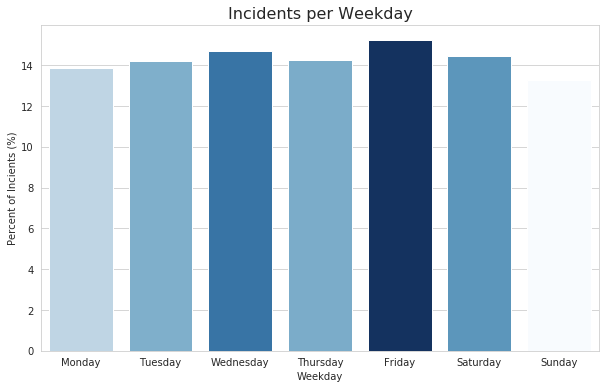

In [56]:
weekday_series = train.groupby('DayOfWeek').count().iloc[:,0]
weekday_series = weekday_series.reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'])

with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(1, figsize=(10, 6))
    sns.barplot(
        weekday_series.index, (weekday_series.values / weekday_series.values.sum()) * 100,
        palette=cm.ScalarMappable(cmap='Blues').to_rgba(weekday_series.values))

plt.title('Incidents per Weekday', fontdict={'fontsize':16})
plt.xlabel('Weekday')
plt.ylabel('Percent of Incients (%)');

금요일에 범죄 건수가 가장 많고, 수요일, 토요일, 목요일 등이 그 뒤를 이었습니다

### Category

In [37]:
category_counts = train.groupby('Category').count().iloc[:, 0].sort_values(ascending=False)

In [38]:
category_counts

Category
LARCENY/THEFT                  174320
OTHER OFFENSES                 125960
NON-CRIMINAL                    91915
ASSAULT                         76815
DRUG/NARCOTIC                   53919
VEHICLE THEFT                   53706
VANDALISM                       44581
WARRANTS                        42145
BURGLARY                        36600
SUSPICIOUS OCC                  31394
MISSING PERSON                  25669
ROBBERY                         22988
FRAUD                           16637
FORGERY/COUNTERFEITING          10592
SECONDARY CODES                  9979
WEAPON LAWS                      8550
PROSTITUTION                     7446
TRESPASS                         7318
STOLEN PROPERTY                  4537
SEX OFFENSES FORCIBLE            4380
DISORDERLY CONDUCT               4313
DRUNKENNESS                      4277
RECOVERED VEHICLE                3132
KIDNAPPING                       2340
DRIVING UNDER THE INFLUENCE      2268
LIQUOR LAWS                      1899
RUN

In [42]:
# OTHER OFFENSES를 제일 아래 두기 위해
category_counts = category_counts.reindex(
    np.append(np.delete(category_counts.index, 1), 'OTHER OFFENSES'))

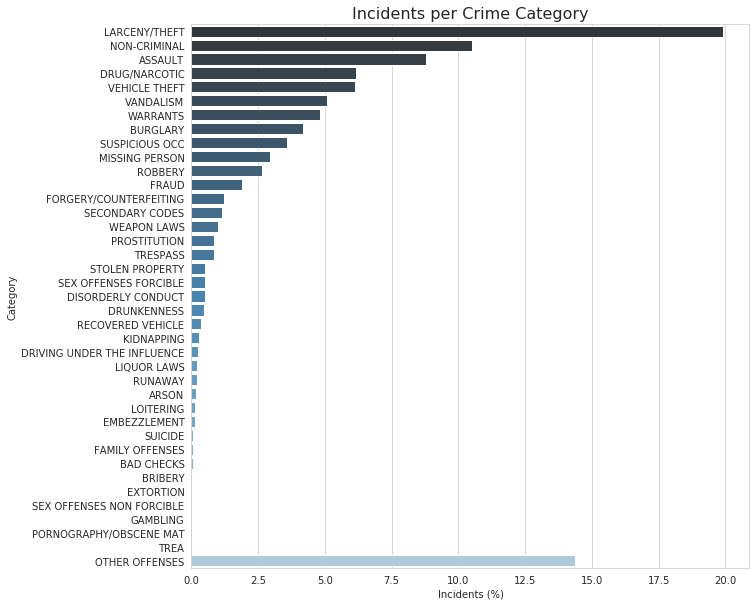

In [57]:
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(1, figsize=(10, 10))
    sns.barplot(
        category_counts.values / category_counts.values.sum() * 100,
        category_counts.index,
        orient='h',
        palette='Blues_d')
plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)');

절도의 비율이 가장 큽니다.

### Police District

샌프란시스코의 Police Distirct를 불러와 train 데이터와 merging시킵니다.

In [135]:
# Downloading the shapefile of the area 
url = 'https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=Shapefile'
with urllib.request.urlopen(url) as response, open('pd_data.zip', 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
    
# Unzipping it
with zipfile.ZipFile('pd_data.zip', 'r') as zip_ref:
    zip_ref.extractall('pd_data')
    
# Loading to a geopandas dataframe
for filename in os.listdir('./pd_data/'):
    if re.match(".+\.shp", filename):
        pd_districts = gpd.read_file('./pd_data/'+filename)
        break
        
# Merging our train dataset with the geo-dataframe
pd_districts = pd_districts.merge(
    train.groupby('PdDistrict').count().iloc[:, [0]].rename(
        columns={'Dates': 'Incidents'}),
    left_on='district',
    right_index=True)

# Transforming the coordinate system to Spherical Mercator for
# compatibility with the tiling background
pd_districts = pd_districts.to_crs({'init': 'epsg:3857'})

# Calculating the incidents per day for every district
train_days = train.groupby('Date').count().shape[0]
pd_districts['inc_per_day'] = pd_districts.Incidents/train_days

각 district별 하루 평균 범죄 발생 건수를 시각화합니다.

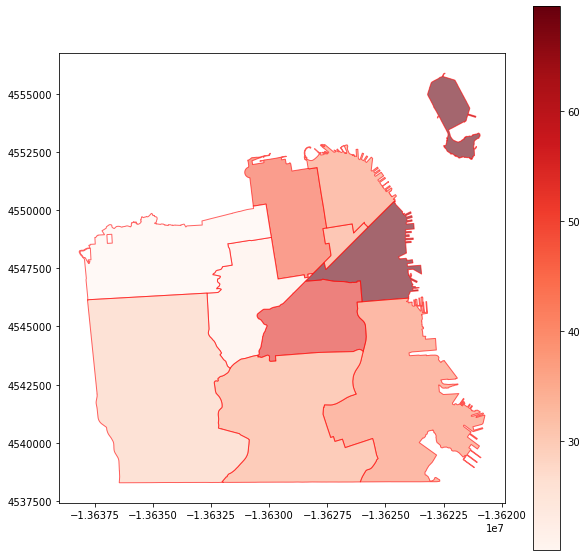

In [136]:
# Ploting the data
fig, ax = plt.subplots(figsize=(10, 10))
pd_districts.plot(
    column='inc_per_day',
    cmap='Reds',
    alpha=0.6,
    edgecolor='r',
    linestyle='-',
    linewidth=1,
    legend=True,
    ax=ax);

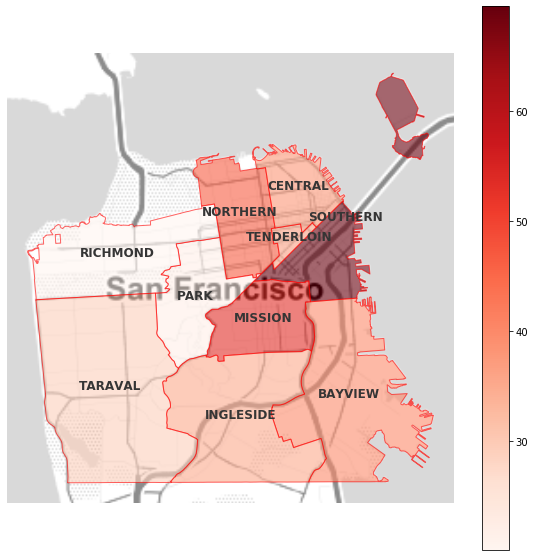

In [137]:
fig, ax = plt.subplots(figsize=(10, 10))
pd_districts.plot(
    column='inc_per_day',
    cmap='Reds',
    alpha=0.6,
    edgecolor='r',
    linestyle='-',
    linewidth=1,
    legend=True,
    ax=ax);

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    """Function that add the tile background to the map"""
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# Adding the background
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

# Adding the name of the districts
for index in pd_districts.index:
    plt.annotate(
        pd_districts.loc[index].district,
        (pd_districts.loc[index].geometry.centroid.x,
         pd_districts.loc[index].geometry.centroid.y),
        color='#353535',
        fontsize='large',
        fontweight='heavy',
        horizontalalignment='center'
    )

ax.set_axis_off()
plt.show()

### Address